In [63]:
import tensorflow as tf
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, SimpleRNN, Embedding, Dropout, SpatialDropout1D, Activation, Conv1D,GRU
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization, Add, Flatten
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from keras.optimizers import adam_v2
from keras.utils.vis_utils import plot_model
from sklearn.model_selection  import train_test_split
#from sklearn.cross_validation import train_test_split

# For custom metrics
import keras.backend as K
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping 


import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt

plt.style.use('seaborn')

import seaborn as sns
from IPython.display import Image

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs
from nltk.tokenize import word_tokenize
import string
import gensim
import os
import re

sns.set_style("whitegrid")
np.random.seed(0)

In [64]:
train = pd.read_csv('train.csv')
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [65]:
train = train.loc[(train['toxic'] == 1) | (train['severe_toxic'] == 1) | (train['obscene'] ==1) | (train['threat'] == 1) | (train['insult'] == 1) | (train['identity_hate'] ==1)]

train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
44,001956c382006abd,I'm Sorry \n\nI'm sorry I screwed around with ...,1,0,0,0,0,0
51,001dc38a83d420cf,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
56,0020fd96ed3b8c8b,=Tony Sidaway is obviously a fistfuckee. He lo...,1,0,1,0,1,0
58,0021fe88bc4da3e6,My Band Page's deletion. You thought I was gon...,1,0,1,0,0,0


In [66]:
totalContentCleaned = []
punctDict = {}
for punct in string.punctuation:
    punctDict[punct] = None
transString = str.maketrans(punctDict)
# since we intent to remove any punctuation with ''
for sen in train['comment_text']:
    
    #cleanedString = re.sub('[^a-zA-Z]+', '', sen)
    
    p = sen.translate(transString)
    totalContentCleaned.append(p)
    

train['comment_text'] = totalContentCleaned
# we can save the file to csv if we want in local machine
#df.to_csv(os.path.join(os.path.abspath('data'), 'train_cleaned.csv'), index = False)



train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey what is it\n talk \nWhat is it an exclusi...,1,0,0,0,0,0
16,0007e25b2121310b,Bye \n\nDont look come or think of comming bac...,1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian \n\nArchangel WHi...,1,0,1,0,1,1
43,00190820581d90ce,FUCK YOUR FILTHY MOTHER IN THE ASS DRY,1,0,1,0,1,0
44,001956c382006abd,Im Sorry \n\nIm sorry I screwed around with so...,1,0,0,0,0,0
51,001dc38a83d420cf,GET FUCKED UP GET FUCKEEED UP GOT A DRINK THA...,1,0,1,0,0,0
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
56,0020fd96ed3b8c8b,Tony Sidaway is obviously a fistfuckee He love...,1,0,1,0,1,0
58,0021fe88bc4da3e6,My Band Pages deletion You thought I was gone ...,1,0,1,0,0,0


In [67]:
df_test = pd.read_csv('test.csv')
df_test.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [68]:
totalContentCleaned = []
punctDict = {}
for punct in string.punctuation:
    punctDict[punct] = None
transString = str.maketrans(punctDict)
# since we intent to remove any punctuation with ''
for sen in df_test['comment_text']:
    
    #cleanedString = re.sub('[^a-zA-Z]+', '', sen)
    
    p = sen.translate(transString)
    totalContentCleaned.append(p)
    

df_test['comment_text'] = totalContentCleaned
# we can save the file to csv if we want in local machine
#df.to_csv(os.path.join(os.path.abspath('data'), 'train_cleaned.csv'), index = False)



df_test.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then youll ...
1,0000247867823ef7,From RfC \n\n The title is fine as it is IMO
2,00013b17ad220c46,\n\n Sources \n\n Zawe Ashton on Lapland —...
3,00017563c3f7919a,If you have a look back at the source the info...
4,00017695ad8997eb,I dont anonymously edit articles at all
5,0001ea8717f6de06,Thank you for understanding I think very highl...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia Such e...
7,000247e83dcc1211,Dear god this site is horrible
8,00025358d4737918,\n Only a fool can believe in such numbers \n...
9,00026d1092fe71cc,Double Redirects \n\n When fixing double red...


In [69]:
df_test_labels = pd.read_csv('test_labels.csv')

df_test_labels.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
5,0001ea8717f6de06,0,0,0,0,0,0
6,00024115d4cbde0f,-1,-1,-1,-1,-1,-1
7,000247e83dcc1211,0,0,0,0,0,0
8,00025358d4737918,-1,-1,-1,-1,-1,-1
9,00026d1092fe71cc,-1,-1,-1,-1,-1,-1


In [70]:
test_labels = df_test_labels[(df_test_labels[['toxic','severe_toxic', 'obscene', 'threat', 
                                        'insult', 'identity_hate']] != -1).all(axis=1)]
test_labels.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,0,0,0,0,0,0
11,0002f87b16116a7f,0,0,0,0,0,0
13,0003e1cccfd5a40a,0,0,0,0,0,0
14,00059ace3e3e9a53,0,0,0,0,0,0
16,000663aff0fffc80,0,0,0,0,0,0
17,000689dd34e20979,0,0,0,0,0,0
19,000844b52dee5f3f,0,0,0,0,0,0
21,00091c35fa9d0465,1,0,0,0,0,0
22,000968ce11f5ee34,0,0,0,0,0,0


In [71]:
test = pd.merge(test_labels, df_test, on='id', how='inner')
test.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
0,0001ea8717f6de06,0,0,0,0,0,0,Thank you for understanding I think very highl...
1,000247e83dcc1211,0,0,0,0,0,0,Dear god this site is horrible
2,0002f87b16116a7f,0,0,0,0,0,0,Somebody will invariably try to add Religion ...
3,0003e1cccfd5a40a,0,0,0,0,0,0,\n\n It says it right there that it IS a type...
4,00059ace3e3e9a53,0,0,0,0,0,0,\n\n Before adding a new product to the list...
5,000663aff0fffc80,0,0,0,0,0,0,this other one from 1897
6,000689dd34e20979,0,0,0,0,0,0,Reason for banning throwing \n\n This articl...
7,000844b52dee5f3f,0,0,0,0,0,0,blocked from editing Wikipedia
8,00091c35fa9d0465,1,0,0,0,0,0,Arabs are committing genocide in Iraq but no ...
9,000968ce11f5ee34,0,0,0,0,0,0,Please stop If you continue to vandalize Wikip...


In [72]:
test = test.loc[(test['toxic'] == 1) | (test['severe_toxic'] == 1) | (test['obscene'] ==1) | (test['threat'] == 1) | (test['insult'] == 1) | (test['identity_hate'] ==1)]

test.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
8,00091c35fa9d0465,1,0,0,0,0,0,Arabs are committing genocide in Iraq but no ...
24,0013fed3aeae76b7,1,0,1,0,1,1,DJ Robinson is gay as hell he sucks his dick s...
29,0017d4d47894af05,1,0,1,0,1,0,Fuck off you antisemitic cunt
38,001d739c97bc2ae4,1,0,0,0,0,0,How dare you vandalize that page about the HMS...
40,001eff4007dbb65b,1,0,1,0,1,0,No he is an arrogant self serving immature idi...
89,005f47397e07e12f,1,0,0,0,0,0,Eek but shes cute in an earthy kind of way Can...
106,0071940212267fea,1,0,1,0,0,0,Well it sucks to have a university to be nickn...
107,0072b9c3697ab8cc,1,0,1,0,1,0,Argh \n\n Some random idiot deleted the whol...
124,0081b14d79f54b31,1,0,1,1,0,0,we hate america and we are going to bomb the s...
125,00842d1024b19972,1,0,1,0,1,0,Bold textYOU SUCK \n\n \n\n U SUCK HANNAH M...


In [73]:
print("Train data shape", train.shape)
print("Test data shape", test.shape)

Train data shape (16225, 8)
Test data shape (6243, 8)


In [74]:
# check that there are no missing values in either training set
print('The dataset has', train.isna().sum().sum(), 'missing values in train data.')
print('The dataset has', test.isna().sum().sum(), 'missing values in test data.')

# check if there are any duplicates
print('The dataset has', train.duplicated().sum(), 'duplicates in train data.')
print('The dataset has', test.duplicated().sum(), 'duplicates in test data.')

The dataset has 0 missing values in train data.
The dataset has 0 missing values in test data.
The dataset has 0 duplicates in train data.
The dataset has 0 duplicates in test data.


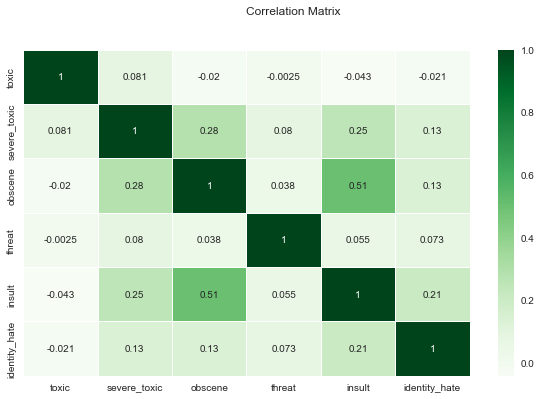

In [75]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Correlation Matrix')
sns.heatmap(train.corr(), annot=True, cmap="Greens", linewidths=.5, ax=ax);

In [76]:
#Convert text to vectors using keras preprocessing library tools

X_train = train["comment_text"].values
X_test  = test["comment_text"].values

y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
y_test  = test[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

In [77]:
num_words = 20000 #Max. workds to use per toxic comment
max_features = 200000 #Max. number of unique words in embeddinbg vector
max_len = 200 #Max. number of words per toxic comment to be use
embedding_dims = 128 #embedding vector output dimension 
num_epochs = 10 # (before 5)number of epochs (number of times that the model is exposed to the training dataset)
val_split = 0.1
batch_size2 = 256 #(before 32)The **batch size** is the number of training examples in one forward/backward pass.
                  # In general, larger batch sizes result in faster progress in training, but don't always converge as quickly. 
                  #Smaller batch sizes train slower, but can converge faster. And the higher the batch size, the more memory space you’ll need.

In [78]:
#toxic comments Tokenization
tokenizer = tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(list(X_train))

#Convert tokenized toxic commnent to sequnces
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
 
# padding the sequences
X_train = sequence.pad_sequences(X_train, max_len)
X_test  = sequence.pad_sequences(X_test,  max_len)

print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape: (16225, 200)
X_test shape:  (6243, 200)


In [79]:
X_tra, X_val, y_tra, y_val = train_test_split(X_train, y_train, train_size =0.9, random_state=233)

In [80]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=4)

In [81]:
toxicComments_lines = list()
lines = train['comment_text'].values.tolist()

for line in lines:
    tokens = word_tokenize(line)
    
    #convert to lower case
    tokens = [w.lower() for w in tokens]
    
    #remove punctuation from each word
    table =  str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    #remove remaining tpkens gthat are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    
    #filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    toxicComments_lines.append(words)


len(toxicComments_lines)

16225

In [82]:
#train word2vec mode
embedding_dims = 100 #embedding vector output dimension 
max_len = 200 #Max. number of words per toxic comment to be use
word2VecModel = gensim.models.Word2Vec(sentences=toxicComments_lines, window=5, workers=4, min_count=1)
#vocab size
words = list(word2VecModel.wv.index_to_key)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 36870


In [83]:
#save model
filename = 'toxic_embedding_word2vec.txt'
word2VecModel.wv.save_word2vec_format(filename, binary=False)

In [84]:
word2Vec_embeddings_index = {}
word2vec_file = open(os.path.join('', 'toxic_embedding_word2vec.txt'), encoding = "utf-8")

for line in word2vec_file:
    values = line.split()
    word = values[0]
    coefficient = np.asarray(values[1:])
    word2Vec_embeddings_index[word] = coefficient
word2vec_file.close()

In [85]:
#vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(toxicComments_lines)
sequences = tokenizer_obj.texts_to_sequences(toxicComments_lines)

#pad sequences
word_index = tokenizer_obj.word_index
print('Found %s uniquue tokens.' % len(word_index))

toxicComments_pad = pad_sequences(sequences, maxlen=max_len)
comments_tag = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
print('Shape of toxic comments tensor', toxicComments_pad.shape)
print('Shape of comment tensor', comments_tag.shape)

Found 36870 uniquue tokens.
Shape of toxic comments tensor (16225, 200)
Shape of comment tensor (16225, 6)


In [86]:
num_words = len(word_index)+1
word2Vec_embedding_matrix = np.zeros((num_words, embedding_dims))

for word, i  in word_index.items():
    if i > num_words:
        continue
    word2Vec_embedding_vector = word2Vec_embeddings_index.get(word)
    if word2Vec_embedding_vector is not None:
        #words not found in embedding index will be all-zeros.
        word2Vec_embedding_matrix[i] = word2Vec_embedding_vector

print(num_words)
print(word2Vec_embedding_matrix.shape[0])
print(word2Vec_embedding_matrix.shape[1])

36871
36871
100


In [87]:
LSTM_Word2Vec_model = Sequential([
    Embedding(input_dim =word2Vec_embedding_matrix.shape[0], input_length=max_len, output_dim=word2Vec_embedding_matrix.shape[1],weights=[word2Vec_embedding_matrix], trainable=False),
    SpatialDropout1D(0.5),
    #Bidirectional layer will enable our model to predict a missing word in a sequence, 
    #So, using this feature will enable the model to look at the context on both the left and the right.
    LSTM(25, return_sequences=True),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

LSTM_Word2Vec_model.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam(0.01), metrics=['accuracy'])

In [88]:
LSTM_Word2Vec_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 100)          3687100   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 200, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 200, 25)           12600     
                                                                 
 batch_normalization_1 (Batc  (None, 200, 25)          100       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 200, 25)           0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 25)              

In [89]:
LSTM_Word2Vec_model_fit = LSTM_Word2Vec_model.fit(X_tra, y_tra, batch_size=batch_size2, epochs=num_epochs, validation_data=(X_val, y_val))

Epoch 1/10
58/58 [==============================] - 64s 857ms/step - loss: 0.4537 - accuracy: 0.9219 - val_loss: 0.5326 - val_accuracy: 0.9476
Epoch 2/10
58/58 [==============================] - 47s 803ms/step - loss: 0.3891 - accuracy: 0.9421 - val_loss: 0.5052 - val_accuracy: 0.9476
Epoch 3/10
58/58 [==============================] - 39s 676ms/step - loss: 0.3838 - accuracy: 0.9421 - val_loss: 0.4858 - val_accuracy: 0.9476
Epoch 4/10
58/58 [==============================] - 58s 988ms/step - loss: 0.3797 - accuracy: 0.9419 - val_loss: 0.4415 - val_accuracy: 0.9476
Epoch 5/10
58/58 [==============================] - 49s 850ms/step - loss: 0.3792 - accuracy: 0.9421 - val_loss: 0.4559 - val_accuracy: 0.9476
Epoch 6/10
58/58 [==============================] - 45s 781ms/step - loss: 0.3762 - accuracy: 0.9421 - val_loss: 0.4227 - val_accuracy: 0.9476
Epoch 7/10
58/58 [==============================] - 46s 792ms/step - loss: 0.3742 - accuracy: 0.9421 - val_loss: 0.4111 - val_accuracy: 0.9476

In [90]:
#train
LSTM_Word2Vec_train_score = LSTM_Word2Vec_model.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', LSTM_Word2Vec_train_score[0])
print('Train Accuracy:', LSTM_Word2Vec_train_score[1])

#test
LSTM_Word2Vec_test_score = LSTM_Word2Vec_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', LSTM_Word2Vec_test_score[0])
print('Test Accuracy:', LSTM_Word2Vec_test_score[1])

64/64 [==============================] - 21s 316ms/step - loss: 0.4134 - accuracy: 0.9426
Train Loss: 0.4133988618850708
Train Accuracy: 0.9426194429397583
25/25 [==============================] - 7s 288ms/step - loss: 0.4164 - accuracy: 0.9755
Test Loss: 0.4163997173309326
Test Accuracy: 0.975492537021637


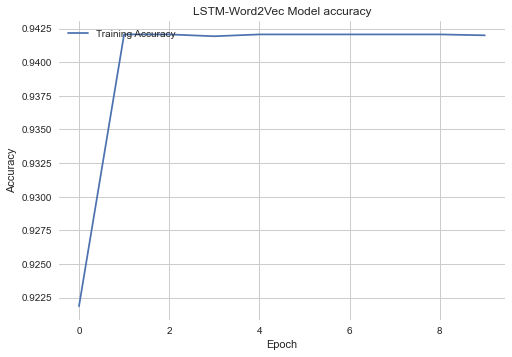

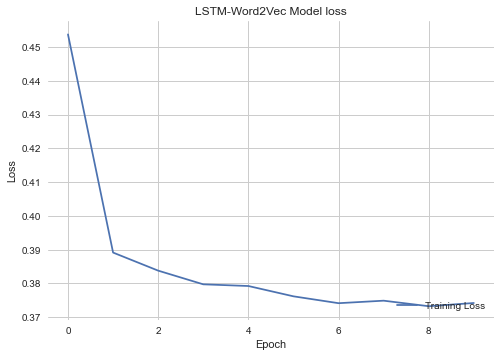

In [93]:
### Plot Training & Validation Accuracy with the Loss values of the LSTM-Glove Model# Plot training & validation accuracy values
plt.plot(LSTM_Word2Vec_model_fit.history['accuracy'])
# plt.plot(LSTM_Word2Vec_model_fit.history['val_acc'])
plt.title('LSTM-Word2Vec Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(LSTM_Word2Vec_model_fit.history['loss'])
plt.title('LSTM-Word2Vec Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss'], loc='lower right')
plt.show()